<a href="https://colab.research.google.com/github/Mazennaji/smart-study-time/blob/main/smart_study_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



In [104]:
np.random.seed(42)
rows = 600

study_hours = np.random.uniform(0, 8, rows)
sleep_hours = np.random.uniform(4, 9, rows)
attendance = np.random.uniform(60, 100, rows)
previous_grade = np.random.uniform(40, 95, rows)

final_score = (
    study_hours * 8 +
    sleep_hours * 4 +
    attendance * 0.25 +
    previous_grade * 0.45 +
    np.random.normal(0, 5, rows)
)

df = pd.DataFrame({
    "study_hours": study_hours.round(2),
    "sleep_hours": sleep_hours.round(2),
    "attendance_percent": attendance.round(1),
    "previous_grade": previous_grade.round(1),
    "final_score": final_score.round(1)
})

df.to_csv("student_performance.csv", index=False)
df.head()


,study_hours,sleep_hours,attendance_percent,previous_grade,final_score
0,3.00,4.84,90.3,92.6,104.8
1,7.61,5.39,61.0,80.6,132.9
2,5.86,4.89,60.9,59.4,99.9
3,4.79,4.44,72.9,56.3,95.6
4,1.25,4.60,79.5,59.2,79.8


# **Exploratory Data Analysis(EDA)**

In [105]:
df.describe()


,study_hours,sleep_hours,attendance_percent,previous_grade,final_score
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,4.024317,6.476450,79.771167,67.609000,108.465000
std,2.386795,1.454794,11.633778,15.684708,21.557353
min,0.040000,4.020000,60.200000,40.100000,59.700000
25%,1.937500,5.160000,69.375000,54.300000,92.875000
50%,4.140000,6.500000,79.800000,68.300000,109.300000
75%,6.105000,7.740000,89.300000,81.025000,124.700000
max,8.000000,8.990000,100.000000,94.900000,157.100000


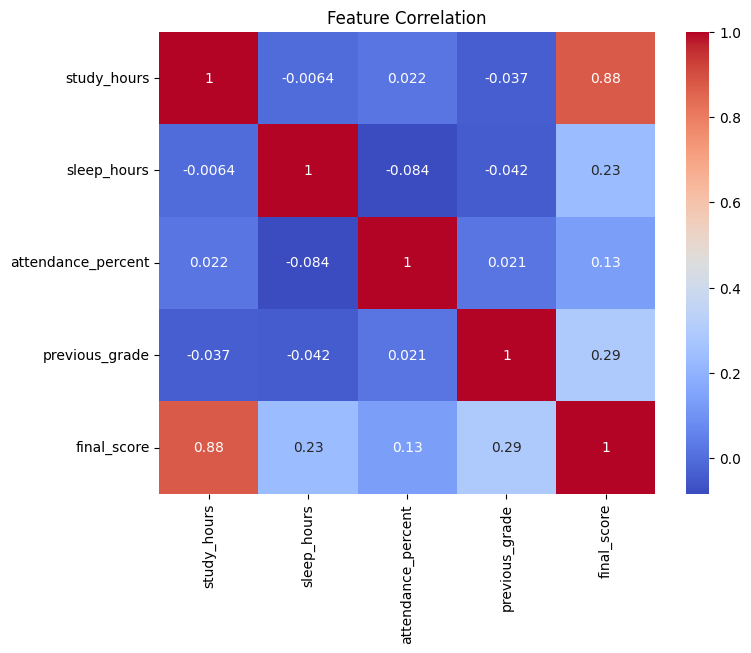

In [106]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()



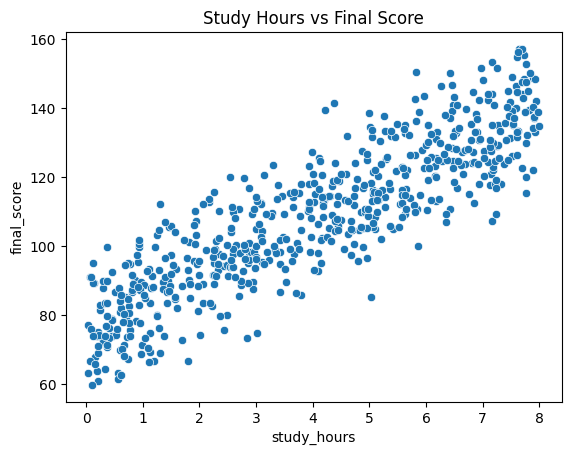

In [107]:
sns.scatterplot(data=df, x="study_hours", y="final_score")
plt.title("Study Hours vs Final Score")
plt.show()



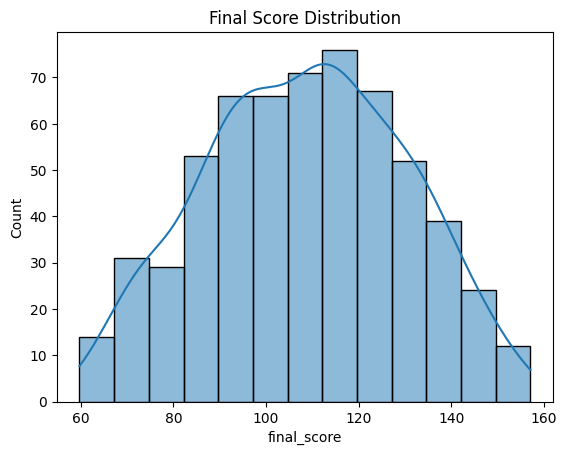

In [108]:
sns.histplot(df["final_score"], kde=True)
plt.title("Final Score Distribution")
plt.show()


# **Unsupervised Learning – K-Means Clustering**

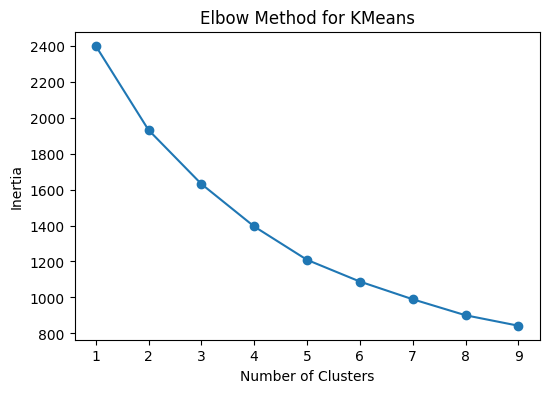

In [109]:
X_cluster = df[["study_hours", "sleep_hours", "attendance_percent", "previous_grade"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,10), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()



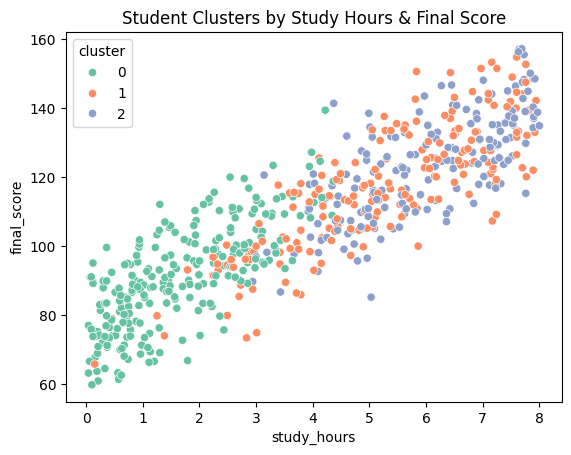

In [110]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(data=df, x="study_hours", y="final_score", hue="cluster", palette="Set2")
plt.title("Student Clusters by Study Hours & Final Score")
plt.show()


In [111]:
df.groupby("cluster").mean().round(2)



,study_hours,sleep_hours,attendance_percent,previous_grade,final_score
cluster,,,,,
0,1.63,6.42,81.45,70.63,90.87
1,5.22,7.38,70.53,62.56,116.87
2,5.92,5.58,87.52,69.04,122.78


# **Supervised Learning – Linear Regression**

In [112]:
X = df[["study_hours", "sleep_hours", "attendance_percent", "previous_grade"]]
y = df["final_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("R2 Score:", round(r2_score(y_test, preds),3))
print("MAE:", round(mean_absolute_error(y_test, preds),2))



R2 Score: 0.948
MAE: 4.07


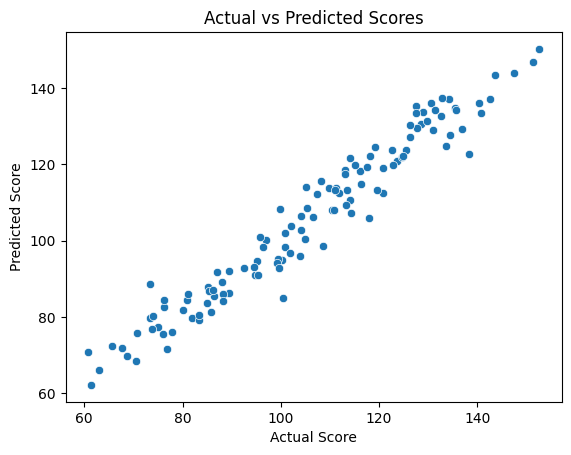

In [113]:
sns.scatterplot(x=y_test, y=preds)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Scores")
plt.show()


# **Reinforcement Learning – Q-Learning Setup**

In [114]:
actions = list(range(9))
Q = np.zeros((9, len(actions)))

alpha = 0.1
gamma = 0.9
epsilon = 0.2

def choose_action(state):
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    return np.argmax(Q[state])

def update(state, action, reward, next_state):
    Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])


# **RL Environment Function**

In [115]:
def get_reward(study_hours):
    sleep = 7
    attendance = 85
    prev_grade = 75

    features = pd.DataFrame(
        [[study_hours, sleep, attendance, prev_grade]],
        columns=["study_hours", "sleep_hours", "attendance_percent", "previous_grade"]
    )

    return model.predict(features)[0]


# **Train RL Agent**

In [116]:
episodes = 1000

for _ in range(episodes):
    state = np.random.randint(0,9)

    action = choose_action(state)
    reward = get_reward(action)

    next_state = action
    update(state, action, reward, next_state)

best_hours = np.argmax(Q.mean(axis=0))
print("Optimal Study Hours Learned:", best_hours)


Optimal Study Hours Learned: 0


# **RL Visualization – Optimization Curve**

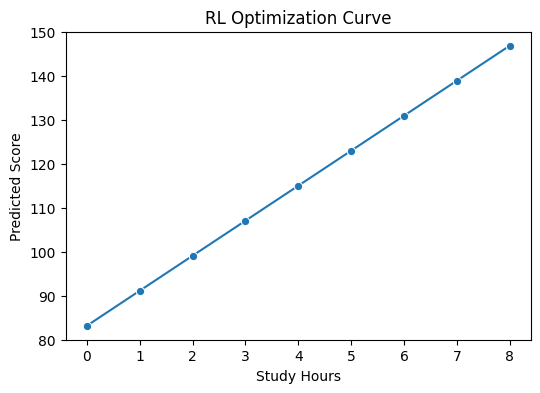

In [117]:
scores = [get_reward(h) for h in range(9)]

plt.figure(figsize=(6,4))
sns.lineplot(x=list(range(9)), y=scores, marker="o")
plt.xlabel("Study Hours")
plt.ylabel("Predicted Score")
plt.title("RL Optimization Curve")
plt.show()



# **Q-Table Heatmap**

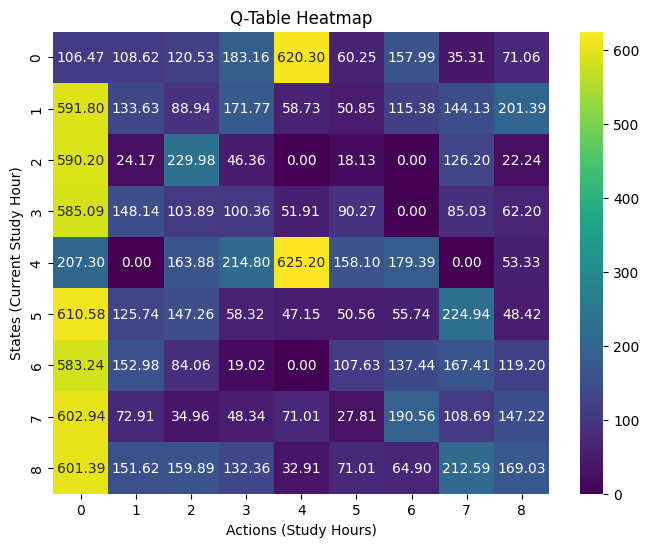

In [118]:
plt.figure(figsize=(8,6))
sns.heatmap(Q, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Q-Table Heatmap")
plt.xlabel("Actions (Study Hours)")
plt.ylabel("States (Current Study Hour)")
plt.show()
